# Shallow Water Tutorial 2d with JAX (Simple)


::: {.callout-note title="Reference"}
The following verification is based on the paper: 

```
 @article{Delestre_2013, 
 title={SWASHES: a compilation of Shallow Water Analytic Solutions for Hydraulic and Environmental Studies}, 
 volume={72}, 
 ISSN={0271-2091, 1097-0363}, DOI={10.1002/fld.3741}, 
 note={arXiv:1110.0288 [physics]}, 
 number={3}, 
 journal={International Journal for Numerical Methods in Fluids}, 
 author={Delestre, Olivier and Lucas, Carine and Ksinant, Pierre-Antoine and Darboux, Frédéric and Laguerre, Christian and Vo, Thi Ngoc Tuoi and James, Francois and Cordier, Stephane}, 
 year={2013}, 
 month=may, 
 pages={269–300} 
}
```

:::

## Imports

In [11]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false


import os
import numpy as np
import pytest
from sympy import Matrix

import sys
if "pyodide" in sys.modules:
    import micropip
    await micropip.install("zoomy-core")
    

from zoomy_jax.fvm.solver_jax import HyperbolicSolver, Settings
from zoomy_core.fvm.solver_numpy import HyperbolicSolver as NumpyHyperbolicSolver
from zoomy_core.model.basemodel import Model
from attr import field, define
import zoomy_core.model.initial_conditions as IC
import zoomy_core.model.boundary_conditions as BC
import zoomy_core.misc.io as io
from zoomy_jax.mesh.mesh import compute_derivatives
from zoomy_core.misc.misc import Zstruct, ZArray
from tests.pdesoft import plots_paper
from zoomy_core.fvm import timestepping

import zoomy_core.misc.misc as misc
import zoomy_core.mesh.mesh as petscMesh
import zoomy_core.postprocessing.postprocessing as postprocessing


In [10]:
misc.get_main_directory()

'/home/ingo/Git/Zoomy'

In [2]:
@define(frozen=True, slots=True, kw_only=True)
class SWE(Model):
    dimension: int = 1
    variables: Zstruct = field(init=False)
    aux_variables: Zstruct = field(default=1)
    _default_parameters: dict = field(
        init=False, factory=lambda: {"g": 9.81, "ex": 0.0, "ey": 0.0, "ez": 1.0}
    )
    
    def __attrs_post_init__(self):
        object.__setattr__(self, "variables", self.dimension + 1)
        super().__attrs_post_init__()

    def project_2d_to_3d(self):
        out = ZArray.zeros(6)
        dim = self.dimension
        z = self.position[2]
        b = 0
        h = self.variables[0]
        U = [hu / h for hu in self.variables[1 : 1 + dim]]
        rho_w = 1000.0
        g = 9.81
        out[0] = b
        out[1] = h
        out[2] = U[0]
        out[3] = 0 if dim == 1 else U[1]
        out[4] = 0
        out[5] = rho_w * g * h * (1 - z)
        return out

    def flux(self):
        dim = self.dimension
        h = self.variables[0]
        U = Matrix([hu / h for hu in self.variables[1 : 1 + dim]])
        g = self.parameters.g
        I = Matrix.eye(dim)
        F = Matrix.zeros(self.variables.length(), dim)
        F[0, :] = h * U.T
        F[1:, :] = h * U * U.T + g / 2 * h**2 * I

        return F


In [7]:


bcs = BC.BoundaryConditions(
    [
        BC.Extrapolation(tag="wall"),
        BC.Extrapolation(tag="inflow"),
        BC.Extrapolation(tag="outflow"),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] < 5.0, 0.005, 0.001)
    return Q


ic = IC.UserFunction(custom_ic)

model = SWE(
    dimension=2,
    boundary_conditions=bcs,
    initial_conditions=ic,
)

main_dir = misc.get_main_directory()

mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_quad_2d/mesh.msh")
)

class SWESolver(NumpyHyperbolicSolver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        # dudx = compute_derivatives(Q[1]/Q[0], mesh, derivatives_multi_index=[[0, 0]])[:,0]
        # dvdy = compute_derivatives(Q[2]/Q[0], mesh, derivatives_multi_index=[[0, 1]])[:,0]
        # Qaux = Qaux.at[0].set(dudx)
        # Qaux = Qaux.at[1].set(dvdy)
        return Qaux
    
settings = Settings(name="ShallowWater", output=Zstruct(directory="outputs/shallow_water_2d", filename="swe", clean_directory=True))
solver = SWESolver(time_end=6, settings=settings, compute_dt=timestepping.adaptive(CFL=0.45),)
Qnew, Qaux = solver.solve(mesh, model)

AttributeError: module 'zoomy_core.misc' has no attribute 'get_main_directory'

In [ ]:
sys.path

['/home/ingo/Git/Zoomy/web/tutorials/swe',
 '/home/ingo/Git/Zoomy/library',
 '/home/ingo/miniforge3/envs/zoomy/lib/python312.zip',
 '/home/ingo/miniforge3/envs/zoomy/lib/python3.12',
 '/home/ingo/miniforge3/envs/zoomy/lib/python3.12/lib-dynload',
 '',
 '/home/ingo/.local/lib/python3.12/site-packages',
 '/home/ingo/miniforge3/envs/zoomy/lib/python3.12/site-packages']

In [ ]:
import zoomy_core
print("zoomy_core loaded from:", zoomy_core.__file__)


zoomy_core loaded from: /home/ingo/Git/Zoomy/library/zoomy_core/__init__.py


In [ ]:
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.output.filename}.h5"))
postprocessing.vtk_project_2d_to_3d(model, settings, filename='out_3d')

2025-11-07 07:45:39.904 | INFO     | zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:70 - Converted snapshot 0/10
2025-11-07 07:45:39.906 | INFO     | zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:70 - Converted snapshot 1/10
2025-11-07 07:45:39.908 | INFO     | zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:70 - Converted snapshot 2/10
2025-11-07 07:45:39.910 | INFO     | zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:70 - Converted snapshot 3/10
2025-11-07 07:45:39.913 | INFO     | zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:70 - Converted snapshot 4/10
2025-11-07 07:45:39.915 | INFO     | zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:70 - Converted snapshot 5/10
2025-11-07 07:45:39.917 | INFO     | zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:70 - Converted snapshot 6/10
2025-11-07 07:45:39.920 | INFO     | zoomy_core.postprocessing.postprocessing:vtk_project_2d_to_3d:70 - 

/home/ingo/Git/Zoomy/outputs/shallow_water_2d out.9 /home/ingo/Git/Zoomy/outputs/shallow_water_2d/out
/home/ingo/Git/Zoomy/outputs/shallow_water_2d out_3d.9 /home/ingo/Git/Zoomy/outputs/shallow_water_2d/out_3d


{'length': 10.0, 'width': None, 'dx': 0.2, 'dy': None, 'ncellx': 50.0, 'ncelly': None}


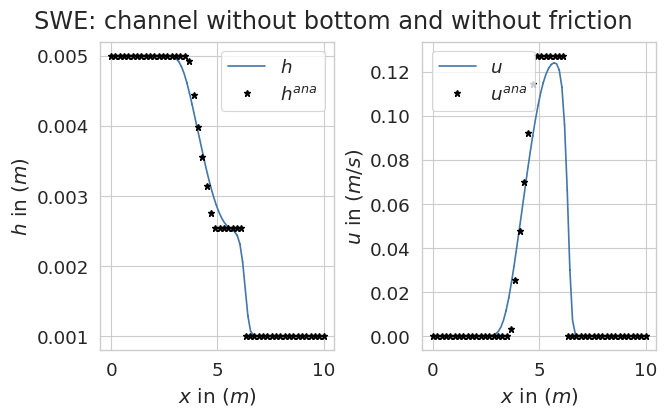

In [ ]:
fig = plots_paper.plot_swe(os.path.join(settings.output.directory, settings.output.filename + ".h5"))

In [ ]:
@pytest.mark.nbworking
def test_working():
    assert True